# ImageNet PaliGemma SAE Training

### Import libraries and define SAE class

In [1]:
import torch
import tensorflow as tf
import tensorflow_datasets as tfds
from concurrent.futures import ThreadPoolExecutor
from torchvision.utils import make_grid
import requests
from transformers import AutoProcessor, PaliGemmaForConditionalGeneration
from datasets import load_dataset
from torch import nn, Tensor
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import gc
import wandb
from datetime import datetime
import torch
import torch.nn as nn
from torch.cuda.amp import autocast
import os
import multiprocessing
from datasets import Dataset
import numpy as np
from PIL import Image
from IPython import display

DIM_IN = 2048
DIM_HIDDEN = 4096

class SparseAutoencoder(nn.Module):
    def __init__(self, d_in=DIM_IN, d_hidden=DIM_HIDDEN):
        super().__init__()
        self.encoder = nn.Linear(d_in, d_hidden)
        self.activation = nn.ReLU()
        self.decoder = nn.Linear(d_hidden, d_in)

    def forward(self, x):
        z = self.activation(self.encoder(x))
        x_recon = self.decoder(z)
        return x_recon, z

dtype = torch.float16
if torch.cuda.is_available():
    torch.cuda.set_device(1)  # Set current device to 1
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    dtype = torch.bfloat16

device = "cuda:1" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

2025-05-04 07:35:55.518519: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-04 07:35:55.537210: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746344155.559831   66435 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746344155.566785   66435 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746344155.584067   66435 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Using device: cuda:1


In [2]:
torch.cuda.empty_cache()    # Clears unreferenced memory
gc.collect()  

273

### Loading DROID dataset

In [3]:
def as_gif(images, path="temp.gif"):
  # Render the images as the gif (15Hz control frequency):
  images[0].save(path, save_all=True, append_images=images[1:], duration=int(1000/15), loop=0)
  gif_bytes = open(path,"rb").read()
  return gif_bytes


# ds = tfds.load("droid_100", data_dir="gs://gresearch/robotics", split="train[:50%]")

# images = []
# for episode in ds.shuffle(10, seed=0).take(1):
#   for i, step in enumerate(episode["steps"]):
#     images.append(
#       Image.fromarray(
#         np.concatenate((
#               step["observation"]["exterior_image_1_left"].numpy(),
#               step["observation"]["exterior_image_2_left"].numpy(),
#               step["observation"]["wrist_image_left"].numpy(),
#         ), axis=1)
#       )
#     )

# display.Image(as_gif(images))

In [4]:
import multiprocessing as mp

def load_droid_subset(return_dict):
    import tensorflow_datasets as tfds
    from PIL import Image
    ds = tfds.load("droid_100", data_dir="gs://gresearch/robotics", split="train")
    frames, prompts = [], []
    for episode in ds.take(10):  # limit
        for step in episode["steps"]:
            img = Image.fromarray(step["observation"]["wrist_image_left"].numpy())
            frames.append(img)
            prompts.append(step["language_instruction"].numpy().decode("utf-8"))
    return_dict["frames"] = frames
    return_dict["prompts"] = prompts

manager = multiprocessing.Manager()
return_dict = manager.dict()
p = multiprocessing.Process(target=load_droid_subset, args=(return_dict,))
p.start()
p.join()

frames, prompts = return_dict["frames"], return_dict["prompts"]


2025-05-04 07:36:13.353110: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NOT_INITIALIZED: initialization error
2025-05-04 07:36:13.353160: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-05-04 07:36:13.353170: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] retrieving CUDA diagnostic information for host: cs182-vm3
2025-05-04 07:36:13.353176: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:190] hostname: cs182-vm3
2025-05-04 07:36:13.353253: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:197] libcuda reported version is: 570.86.15
2025-05-04 07:36:13.353274: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:201] kernel reported version 

In [5]:
# SUBDATASET   = "jaco_play"           # or "fractal20220817_data", "kuka", …
# MAX_SAMPLES  = 200                 # how many items you actually want
# SEED         = 42

# # ➊ Download (once) + load
# ds = load_dataset(
#         "jxu124/OpenX-Embodiment",   # 🗂️ repo name on the Hub
#         SUBDATASET,                  # ⚙️  configuration / sub-dataset
#         split="train",
#         streaming=False,             # ⇦ map-style; set True for IterableDataset
#         trust_remote_code=True       # dataset has a custom loading script
# )

# # ➋ Shuffle + take a subset (map-style only)
# ds_small = ds.shuffle(seed=SEED).select(range(MAX_SAMPLES))
# print(ds_small)

In [5]:
# def extract_frames_and_prompts(ds, max_episodes=100, max_steps_per_episode=10):
#     frames, prompts = [], []
#     for episode in ds.take(max_episodes):
#         for i, step in enumerate(episode["steps"]):
#             if i >= max_steps_per_episode:
#                 break
#             try:
#                 image = Image.fromarray(step["observation"]["exterior_image_1_left"].numpy())
#                 if image.mode != "RGB":
#                     image = image.convert("RGB")
#                 frames.append(image)
#                 prompts.append("<image> " + step["language_instruction"].numpy().decode("utf-8"))
#             except Exception as e:
#                 print(f"Skipping due to error: {e}")
#     return frames, prompts
    
# frames, prompts = extract_frames_and_prompts(ds)
droid_data = Dataset.from_dict({
    "image": frames,
    "prompt": prompts
})

In [12]:
frames[0].size

(320, 180)

In [6]:
from torch.utils.data import Dataset

class DroidDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

dataset = DroidDataset(droid_data)

In [15]:
# del ds
# import gc
# gc.collect()

4006

### Load model (takes 55 seconds)

In [7]:
MODEL_ID = "google/paligemma-3b-mix-224"

model = PaliGemmaForConditionalGeneration.from_pretrained(
    MODEL_ID,
    torch_dtype=dtype
).eval()
model = model.to(device) # Move model to GPU
processor = AutoProcessor.from_pretrained(MODEL_ID)

# Set up activation capture (vision tower)
vision_acts = {}
def vision_hook(module, input, output):
    vision_acts["activation"] = output

hook_handle = model.vision_tower.vision_model.encoder.layers[20].register_forward_hook(vision_hook)

Loading checkpoint shards: 100%|███████████████████████████████| 3/3 [00:20<00:00,  6.71s/it]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [13]:
# # === Preprocess images (convert to RGB) ===
# def preprocess(example):
#     image = example["image"]
#     if image.mode != "RGB":
#         image = image.convert("RGB")
#     return {"image": image, "prompt": "<image> caption"}

# def collate_fn(batch):
#     images = [example["image"] for example in batch]
#     prompts = [example["prompt"] for example in batch]
#     return {"images": images, "prompts": prompts}

# dataset = ds_small.map(
#     preprocess,
#     batched=False,
#     num_proc=multiprocessing.cpu_count(),
#     desc="Converting images to RGB"
# )

In [8]:
# === Config ===
BATCH_SIZE = 64 # max size withou OOM error
NUM_WORKERS = 8

def collate_fn(batch):
    images = [example["image"] for example in batch]
    prompts = [example["prompt"] for example in batch]
    return {"images": images, "prompts": prompts}

# === Split dataset across 2 GPUs ===
half = len(dataset) // 2
datasets = [Subset(dataset, range(0, half)), Subset(dataset, range(half, len(dataset)))]
devices = ["cuda:0", "cuda:1"]
activation_lists = [[], []]
token_counts = [[], []]

# === Inference function ===
def run_inference(model, dataloader, device, activations_out, token_counts_out):
    model = model.to(device).eval()
    for batch in tqdm(dataloader, desc=f"Inference on {device}"):
        try:
            images = batch["images"]
            prompts = batch["prompts"]

            model_inputs = processor(
                text=prompts,
                images=images,
                return_tensors="pt",
                padding=True
            )
            model_inputs = {k: v.to(device, non_blocking=True) for k, v in model_inputs.items()}

            with torch.no_grad(), autocast(dtype=torch.bfloat16):
                _ = model(**model_inputs)

            act = vision_acts["activation"]
            if isinstance(act, tuple):
                act = act[0]

            activations_out.append(act.cpu().float())
            token_counts_out.extend([act.shape[1]] * act.size(0))
        except Exception as e:
            print(f"Skipping batch due to error on {device}: {e}")
            continue

# === Run in parallel across both GPUs ===
from threading import Thread

dataloaders = [
    DataLoader(datasets[0], batch_size=BATCH_SIZE, collate_fn=collate_fn,
               num_workers=NUM_WORKERS, pin_memory=True),
    DataLoader(datasets[1], batch_size=BATCH_SIZE, collate_fn=collate_fn,
               num_workers=NUM_WORKERS, pin_memory=True)
]

# Clone model and hook separately for each GPU
import copy
models = [copy.deepcopy(model), copy.deepcopy(model)]

# Register hooks on both models (if needed)
hook_handles = []
for i, m in enumerate(models):
    h = m.vision_tower.vision_model.encoder.layers[20].register_forward_hook(
        lambda module, input, output: vision_acts.update({"activation": output})
    )
    hook_handles.append(h)

# Launch threads
threads = []
for i in range(2):
    t = Thread(target=run_inference, args=(
        models[i], dataloaders[i], devices[i], activation_lists[i], token_counts[i]))
    t.start()
    threads.append(t)

for t in threads:
    t.join()

# Remove hooks
for h in hook_handles:
    h.remove()

# === Merge results ===
all_activations = torch.cat(activation_lists[0] + activation_lists[1], dim=0)
image_to_token_counts = token_counts[0] + token_counts[1]

if all_activations.size(0) == 0:
    raise ValueError("No valid activations collected!")

print("Collected activations:", all_activations.shape)
print("Sum of tokens recorded:", sum(image_to_token_counts))

# Clean up memory
del models, hook_handles, activation_lists, token_counts, datasets, dataloaders, vision_acts
gc.collect()
torch.cuda.empty_cache()


Inference on cuda:1:   0%|                                            | 0/18 [00:00<?, ?it/s]You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
/tmp/ipykernel_66435/3435126631.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast(dtype=torch.bfloat16):
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
You are passing both `t

Collected activations: torch.Size([2302, 256, 1152])
Sum of tokens recorded: 589312


### Save to disk

In [9]:
# Convert to half precision before saving (cuts size in half)
all_activations_fp16 = all_activations.half()
torch.save(all_activations_fp16, "all_activations_fp16.pt")
torch.save(image_to_token_counts, "image_to_token_counts.pt")

### Train SAE

In [10]:
print("image_to_token_counts", image_to_token_counts)

image_to_token_counts [256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 25

In [10]:
# === Initialize Weights & Biases ===
wandb.init(project="sparse-autoencoder", name="SAE-run", config={
    "hidden_multiplier": 8,
    "learning_rate": 1e-4,
    "sparsity_weight": 1e-2,
    "n_epochs": 50,
    "batch_size": 512,
})

# === Hyperparameters ===
hidden_multiplier = wandb.config.hidden_multiplier
learning_rate = wandb.config.learning_rate
sparsity_weight = wandb.config.sparsity_weight
n_epochs = wandb.config.n_epochs
batch_size = wandb.config.batch_size

# === Prepare SAE ===
d_in = all_activations.shape[-1]
d_hidden = hidden_multiplier * d_in

sae = SparseAutoencoder(d_in=d_in, d_hidden=d_hidden).to("cuda:0") 
sae = nn.DataParallel(sae)  # Now wrap for multi-GPU
optimizer = torch.optim.AdamW(sae.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

# === Dataset & Loader ===
train_dataset = torch.utils.data.TensorDataset(all_activations)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

  ········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /home/henrytsai/.netrc
wandb: Currently logged in as: safaamouline (htsai2025) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/home/henrytsai/.local/lib/python3.10/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:181.)
  return F.linear(input, self.weight, self.bias)


Epoch 5: Loss 1.085055
Epoch 10: Loss 0.656323
Epoch 15: Loss 0.439538
Epoch 20: Loss 0.328928
Epoch 25: Loss 0.256083
Epoch 30: Loss 0.204549
Epoch 35: Loss 0.166768
Epoch 40: Loss 0.138295
Epoch 45: Loss 0.116555
Epoch 50: Loss 0.100287
Finished training Sparse Autoencoder!
Saved SAE to checkpoints/sae_2025-05-02_21-45-10.pth


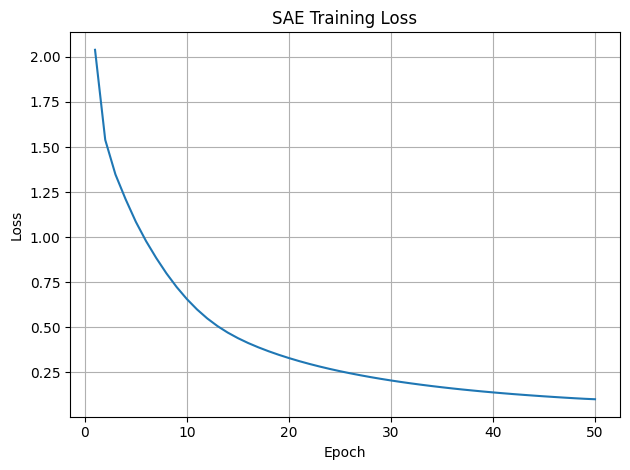

In [11]:
epoch_losses = []

for epoch in range(n_epochs):
    epoch_loss = 0.0
    for batch, in train_loader:
        batch = batch.to("cuda:0", non_blocking=True)
        recon, z = sae(batch)

        loss = loss_fn(recon, batch) + sparsity_weight * torch.mean(torch.abs(z))
        epoch_loss += loss.item() * batch.size(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = epoch_loss / len(train_dataset)
    epoch_losses.append(avg_loss)

    # Log to wandb every epoch
    wandb.log({"loss": avg_loss, "epoch": epoch + 1})

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}: Loss {avg_loss:.6f}")

print("Finished training Sparse Autoencoder!")

# === Save model with timestamp ===
save_dir = "checkpoints"
os.makedirs(save_dir, exist_ok=True)

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_path = os.path.join(save_dir, f"sae_{timestamp}.pth")

torch.save({
    "state_dict": sae.state_dict(),
    "d_in": d_in,
    "d_hidden": d_hidden,
}, model_path)
wandb.save(model_path)

print(f"Saved SAE to {model_path}")

# === Plot loss curve (optional) ===
plt.plot(range(1, n_epochs + 1), epoch_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("SAE Training Loss")
plt.grid(True)
plt.tight_layout()
wandb.log({"loss_curve": wandb.Image(plt)})
plt.show()

### Load previously trained model

In [12]:
# Need to change model path to your own local folder and .pth filename
model_path = "/home/henrytsai/henry/roboterp/checkpoints/sae_2025-05-01_19-00-41.pth"

# === Initialize Weights & Biases ===
wandb.init(project="sparse-autoencoder", name="SAE-run", config={
    "hidden_multiplier": 8,
    "learning_rate": 1e-4,
    "sparsity_weight": 1e-2,
    "n_epochs": 50,
    "batch_size": 512,
})

# === Hyperparameters ===
hidden_multiplier = wandb.config.hidden_multiplier
learning_rate = wandb.config.learning_rate
sparsity_weight = wandb.config.sparsity_weight
n_epochs = wandb.config.n_epochs
batch_size = wandb.config.batch_size

# ==== LOAD METADATA ====
image_to_token_counts = torch.load("image_to_token_counts.pt")
all_activations = torch.load("all_activations_fp16.pt", map_location="cpu")  # shape: [N_images, T, D]
all_activations = all_activations.view(-1, all_activations.shape[-1])        # -> [N_tokens, D]

d_in = all_activations.shape[-1]
d_hidden = hidden_multiplier * d_in

# Define the model
sae = SparseAutoencoder(d_in=d_in, d_hidden=d_hidden)
state_dict = torch.load(model_path, map_location=device)["state_dict"]

# If saved with DataParallel, strip 'module.' prefix
from collections import OrderedDict
if any(k.startswith("module.") for k in state_dict):
    new_state_dict = OrderedDict((k.replace("module.", ""), v) for k, v in state_dict.items())
    state_dict = new_state_dict

# Apply weights
sae.load_state_dict(state_dict)
sae = sae.to(device)
sae.eval()

# Setup SAE model
sae_device = sae.encoder.weight.device
sae_dtype = sae.encoder.weight.dtype

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,50
loss,0.10029


### Visualize features

Top 5 active features: [1768, 6940, 7945, 4305, 1568]


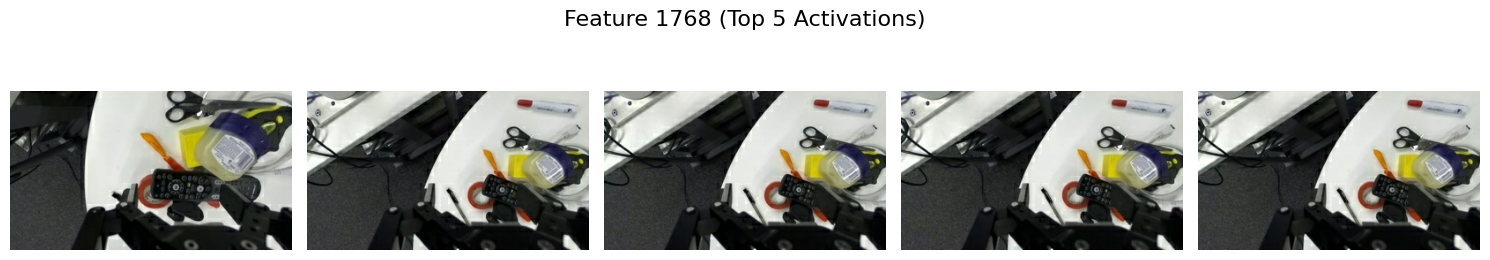

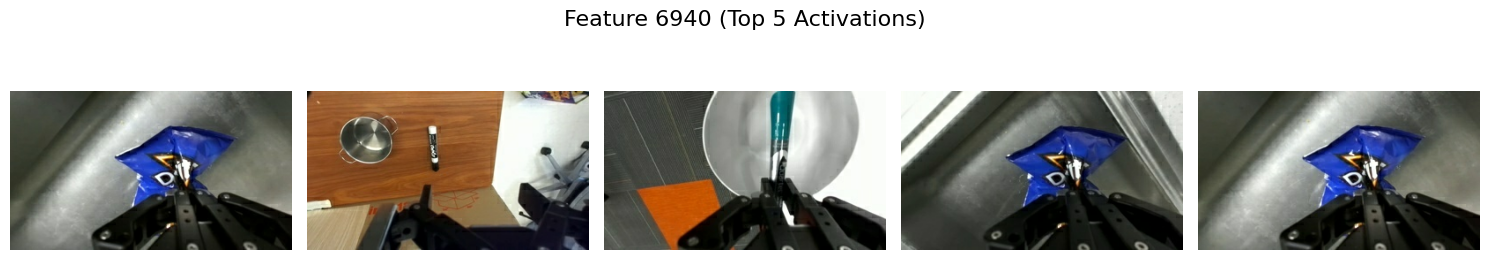

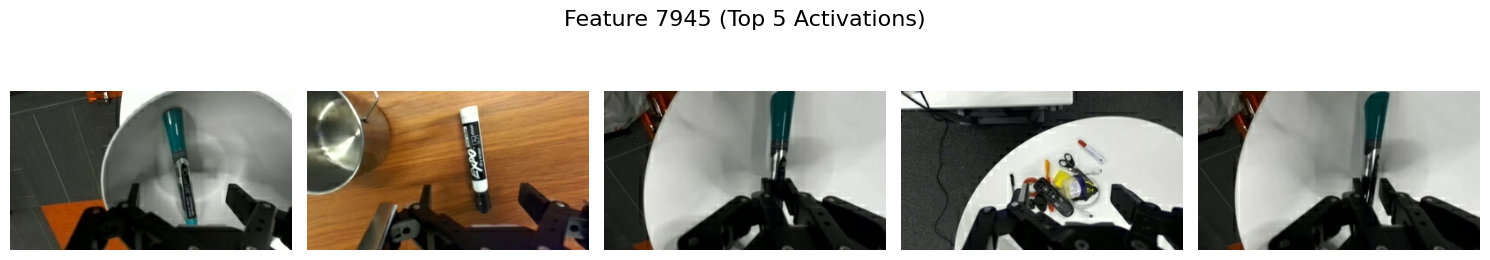

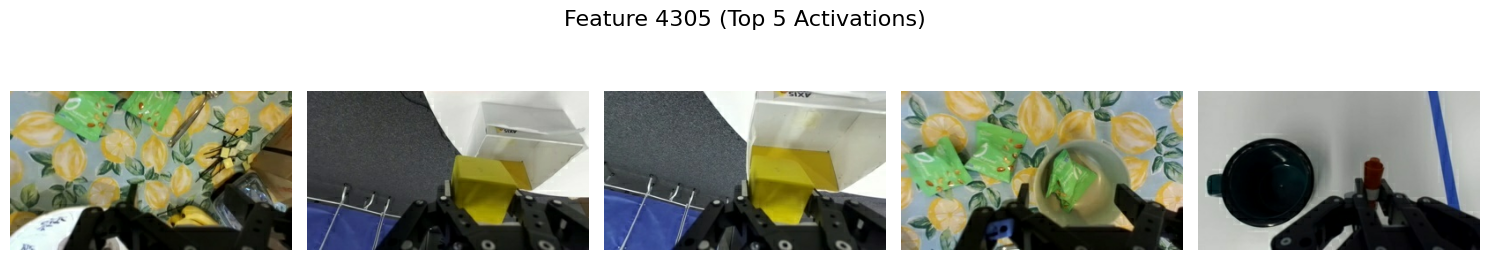

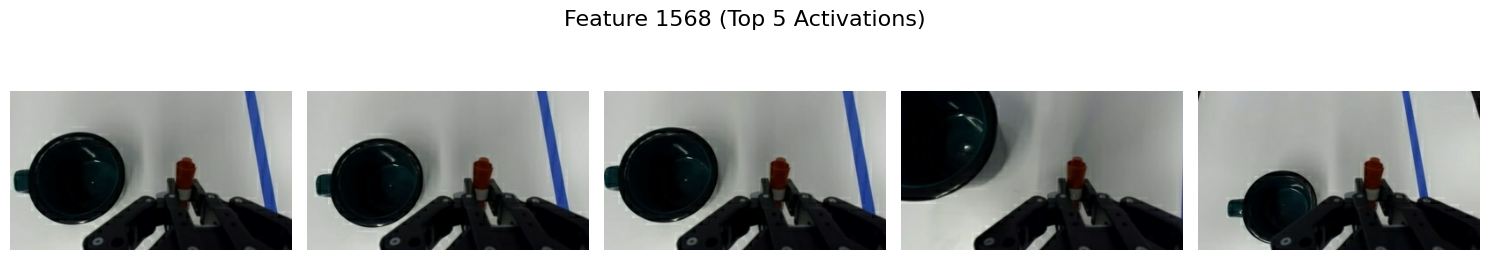

In [13]:
# ==== CONFIG ====
top_k = 5
n_features_to_plot = 5
batch_size = 4096  # tune based on your GPU memory
num_workers = 8    # number of parallel CPU threads


# ==== STREAM ENCODE ====
sparse_feature_list = []
running_sum = torch.zeros(sae.decoder.in_features, device=sae_device)
count = 0

with torch.no_grad():
    for i in range(0, all_activations.size(0), batch_size):
        batch = all_activations[i:i + batch_size].to(device=sae_device, dtype=sae_dtype)
        sparse = sae.activation(sae.encoder(batch))
        running_sum += sparse.sum(dim=0)
        count += sparse.size(0)
        sparse_feature_list.append(sparse.cpu())

sparse_features = torch.cat(sparse_feature_list, dim=0)

# ==== TOKEN-TO-IMAGE INDEX MAPPING ====
image_indices_per_token = []
for img_idx, n_tokens in enumerate(image_to_token_counts):
    image_indices_per_token.extend([img_idx] * n_tokens)

assert len(image_indices_per_token) == sparse_features.shape[0], \
    f"Mismatch: {len(image_indices_per_token)} vs {sparse_features.shape[0]}"

image_indices_per_token = np.array(image_indices_per_token)

# ==== TOP FEATURES ====
mean_features = running_sum / count
top_features = torch.topk(mean_features, k=n_features_to_plot).indices.tolist()
print(f"Top {n_features_to_plot} active features:", top_features)

# ==== PARALLEL IMAGE LOADING ====
def load_rgb(idx):
    img_idx = int(image_indices_per_token[idx])
    image = dataset[img_idx]["image"].convert("RGB")
    return np.array(image)

# ==== DISPLAY ====
for feature_idx in top_features:
    activations = sparse_features[:, feature_idx]
    topk_indices = torch.topk(activations, k=top_k).indices.cpu().tolist()

    # Load top images in parallel
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        images = list(executor.map(load_rgb, topk_indices))

    # Plot
    fig, axes = plt.subplots(1, top_k, figsize=(3 * top_k, 3))
    axes = [axes] if top_k == 1 else axes
    fig.suptitle(f"Feature {feature_idx} (Top {top_k} Activations)", fontsize=16)

    for ax, img in zip(axes, images):
        ax.imshow(img)
        ax.axis("off")

    plt.tight_layout()
    plt.show()


### Sparsity analysis

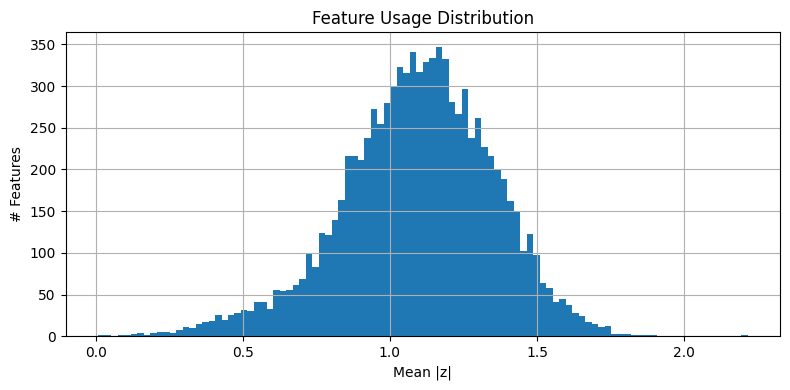

In [14]:
# Assume `sae` is already loaded and on the correct device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
sae = sae.to(device)
sae.eval()

# Compute feature usage (mean |z|) without storing all z
d_hidden = sae.module.encoder.out_features if isinstance(sae, torch.nn.DataParallel) else sae.encoder.out_features
running_sum = torch.zeros(d_hidden, device=device)
count = 0

with torch.no_grad():
    for (batch,) in train_loader:
        batch = batch.to(device, non_blocking=True)
        _, z = sae(batch)                      # shape: [B, d_hidden] or [B, T, d_hidden]
        z = z.view(-1, z.shape[-1])            # flatten in case it's [B, T, d_hidden]
        running_sum += torch.sum(torch.abs(z), dim=0)
        count += z.shape[0]

feature_usage = running_sum / count

# Plot
plt.figure(figsize=(8, 4))
plt.hist(feature_usage.cpu().numpy(), bins=100)
plt.title("Feature Usage Distribution")
plt.xlabel("Mean |z|")
plt.ylabel("# Features")
plt.grid(True)
plt.tight_layout()
plt.show()


### Clean up memory

In [12]:
# del [insert variable]
del d_hidden
torch.cuda.empty_cache()
gc.collect()

650